### Setup

In [ ]:
import numpy as np
from pathlib import Path
import sys

sys.path.append(str(Path.cwd().parent.parent))

from models.nli.common import METRICS_DIR, DATA_DIR

from evaluation.nli.helpers import (
    prepare_nli_tables,
    load_metric_files,
    create_table_b_styler,
    plot_calibration_comparison,
    run_cv_comparison,
    Q2QCalibration,
    IsotonicCalibration,
    to_model_score_data,
    plot_train_test_correlation_from_score_data,
)
from evaluation.core import (
    vis_specific_model_tables,
    vis_specific_model_conf_matrices,
    vis_all_models_plots,
    vis_all_models_tables,
    format_metrics_for_latex,
    load_train_test_data,
)
from evaluation.nli.interface import nli_scores_to_core, get_nli_model_groups

### Tables

In [68]:
SELECTED_DIR = METRICS_DIR
files = sorted(SELECTED_DIR.glob("*.json"))
items = load_metric_files(files)

# Load train/test data for combined correlation computation
df_train, df_test = load_train_test_data(DATA_DIR)

# Clean, simple notebook code
df_a, latex_a, df_b, latex_b, bold_cols = prepare_nli_tables(items, df_train, df_test)

# Display Table A
display(
    df_a.style.format(
        {
            "Best Corr": "{:.3f}",
            **{
                c: "{:.4f}"
                for c in df_a.columns
                if c not in ["#", "Best Corr"]
                and df_a[c].dtype in ["float64", "float32"]
            },
        }
    ).hide(axis="index")
)
print(latex_a)

# Display Table B with all styling/highlighting built-in
styler = create_table_b_styler(df_b, bold_cols)
thr_cols = [c for c in df_b.columns if c.endswith(" Throughput")]
corr_cols = [c for c in df_b.columns if c.endswith(" Corr") and c != "#"]
styler = styler.format(
    {**{c: "{:.1f}" for c in thr_cols}, **{c: "{:.4f}" for c in corr_cols}}
)
display(styler)
print(latex_b)

#,Hypothesis Template,Candidate Labels,Best Corr
1,"This text is {} in terms of visual details of characters, setting, or environment.","not detailed, detailed",0.828
2,"This text is {} in terms of visual details of characters, setting, or environment.","not visual, visual",0.810
3,"This text is {} in terms of visual details of characters, setting, or environment.","not descriptive, descriptive",0.805
4,This text {}.,"lacks environmental context, establishes environment with visual elements",0.763
5,This text includes {}.,"no scene description, scene with location and objects",0.761
6,"This text is {} in terms of sensory details, imagery, characters, environment, and vivid descriptions.","not visual, visual",0.724
7,This text provides {}.,"no spatial context, clear spatial context and arrangement",0.721
8,This text {},"describes abstract concepts without visual imagery, describes a visually complete scene with setting and details",0.719
9,"This text is {} in terms of sensory details, imagery, and vivid descriptions.","not visual, visual",0.718
10,This text {}.,"does not describe appearance, describes physical appearance",0.709


\begin{tabular}{lrrr}
\hline
\# & Hypothesis Template & Candidate Labels & Best Corr \\
\hline
1 & This text is \{\} in terms of visual details of characters, setting, or environment. & not detailed, detailed & 0.828 \\
2 & This text is \{\} in terms of visual details of characters, setting, or environment. & not visual, visual & 0.810 \\
3 & This text is \{\} in terms of visual details of characters, setting, or environment. & not descriptive, descriptive & 0.805 \\
4 & This text \{\}. & lacks environmental context, establishes environment with visual elements & 0.763 \\
5 & This text includes \{\}. & no scene description, scene with location and objects & 0.761 \\
6 & This text is \{\} in terms of sensory details, imagery, characters, environment, and vivid descriptions. & not visual, visual & 0.724 \\
7 & This text provides \{\}. & no spatial context, clear spatial context and arrangement & 0.721 \\
8 & This text \{\} & describes abstract concepts without visual imagery, describes a

#,RoBERTa Corr,MBERT-L Corr,DeBERTa-L Corr,RoBERTa Throughput,MBERT-L Throughput,DeBERTa-L Throughput
1,0.8281,0.7283,0.5091,38.9,14.1,13.1
2,0.8103,0.7520,0.5574,35.6,14.1,13.2
3,0.8050,0.7242,0.5264,35.4,13.9,13.8
4,0.7633,0.6637,0.5850,38.2,15.2,14.3
5,0.7609,0.6766,0.5860,38.4,15.2,13.8
6,0.7235,0.7007,0.6349,34.3,14.3,12.9
7,0.7214,0.5266,0.3888,39.0,14.3,14.2
8,0.5279,0.7189,0.7042,39.1,13.9,13.2
9,0.6683,0.7178,0.6379,34.7,13.9,12.5
10,0.7091,0.4271,0.6603,36.9,15.2,13.8


\begin{tabular}{lrrrrrr}
\hline
\multirow{2}{*}{\#} & \multicolumn{3}{c}{Pearson correlation coefficient} & \multicolumn{3}{c}{Throughput (predictions/sec)} \\
 & RoBERTa & MBERT-L & DeBERTa-L & RoBERTa & MBERT-L & DeBERTa-L \\
\hline
1 & \textbf{0.8281} & 0.7283 & 0.5091 & 38.9 & 14.1 & 13.1 \\
2 & 0.8103 & \textbf{0.7520} & 0.5574 & 35.6 & 14.1 & 13.2 \\
3 & 0.8050 & 0.7242 & 0.5264 & 35.4 & 13.9 & 13.8 \\
4 & 0.7633 & 0.6637 & 0.5850 & 38.2 & 15.2 & 14.3 \\
5 & 0.7609 & 0.6766 & 0.5860 & 38.4 & 15.2 & 13.8 \\
6 & 0.7235 & 0.7007 & 0.6349 & 34.3 & 14.3 & 12.9 \\
7 & 0.7214 & 0.5266 & 0.3888 & 39.0 & 14.3 & 14.2 \\
8 & 0.5279 & 0.7189 & \textbf{0.7042} & 39.1 & 13.9 & 13.2 \\
9 & 0.6683 & 0.7178 & 0.6379 & 34.7 & 13.9 & 12.5 \\
10 & 0.7091 & 0.4271 & 0.6603 & 36.9 & 15.2 & 13.8 \\
11 & 0.7051 & 0.6869 & 0.6065 & 37.2 & 14.3 & 13.4 \\
12 & 0.7025 & 0.6730 & 0.6891 & 36.4 & 15.0 & 13.9 \\
13 & 0.5755 & 0.6782 & 0.6133 & 39.1 & 15.4 & 14.2 \\
14 & 0.5880 & 0.6685 & 0.4257 & 35.2 & 14.2 &

### Correlation Matrix


Using configuration 35 of 46


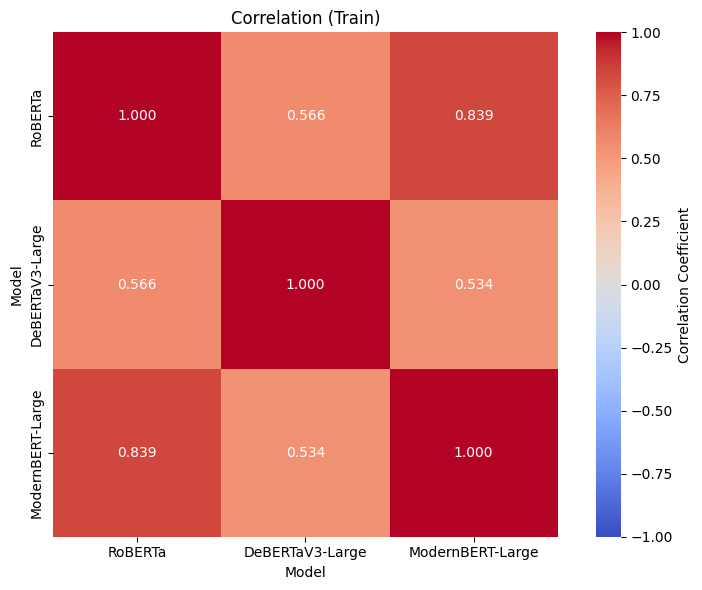

Correlation coefficients:
                   RoBERTa  DeBERTaV3-Large  ModernBERT-Large
RoBERTa           1.000000         0.565521          0.838816
DeBERTaV3-Large   0.565521         1.000000          0.534266
ModernBERT-Large  0.838816         0.534266          1.000000


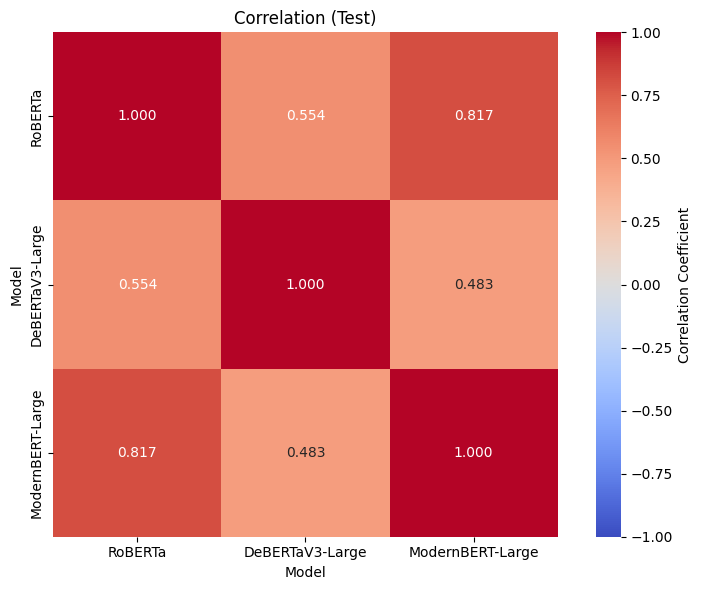

Correlation coefficients:
                   RoBERTa  DeBERTaV3-Large  ModernBERT-Large
RoBERTa           1.000000         0.553883          0.816976
DeBERTaV3-Large   0.553883         1.000000          0.482767
ModernBERT-Large  0.816976         0.482767          1.000000


In [37]:
CONFIG_IDX = 34
print(f"Using configuration {CONFIG_IDX + 1} of {len(items)}")

# Prepare train/test score data for the selected configuration
_df_train, _df_test = load_train_test_data(DATA_DIR)
_score_data = to_model_score_data(items, _df_train, _df_test)

# Plot two correlation matrices: Train and Test
plot_train_test_correlation_from_score_data(_score_data, CONFIG_IDX)

### Calibration Mapping


#### Cross-Validation Comparison: Isotonic vs Q2Q

In [11]:
SELECTED_DIR = METRICS_DIR
files = sorted(SELECTED_DIR.glob("*.json"))
items = load_metric_files(files)

df_train, df_test = load_train_test_data(DATA_DIR)
score_data = to_model_score_data(items, df_train, df_test)

sd = score_data[0] if score_data else None
if sd is None:
    raise RuntimeError("No score data available for CV comparison")

results_df = run_cv_comparison(sd.train_scores, sd.y_train)
print(results_df.to_string(index=False))

  Method  Mean RMSE  Std RMSE  Mean Accuracy  Std Accuracy
Isotonic   0.911326  0.065910       0.431321      0.037675
     Q2Q   1.001659  0.071671       0.476988      0.019297


#### Isotonic vs Q2Q visualization

Selected model: richardr1126/roberta-base-zeroshot-v2.0-c-ONNX
Train scores: (392,) values


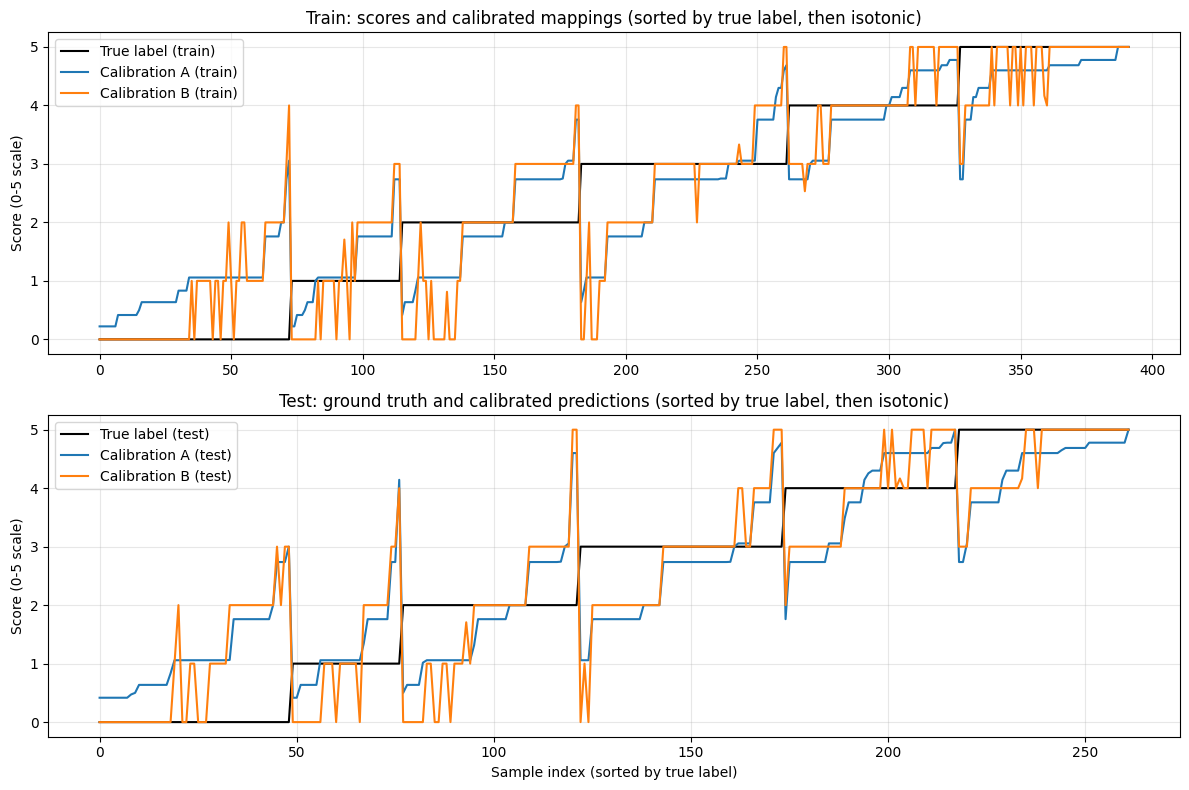

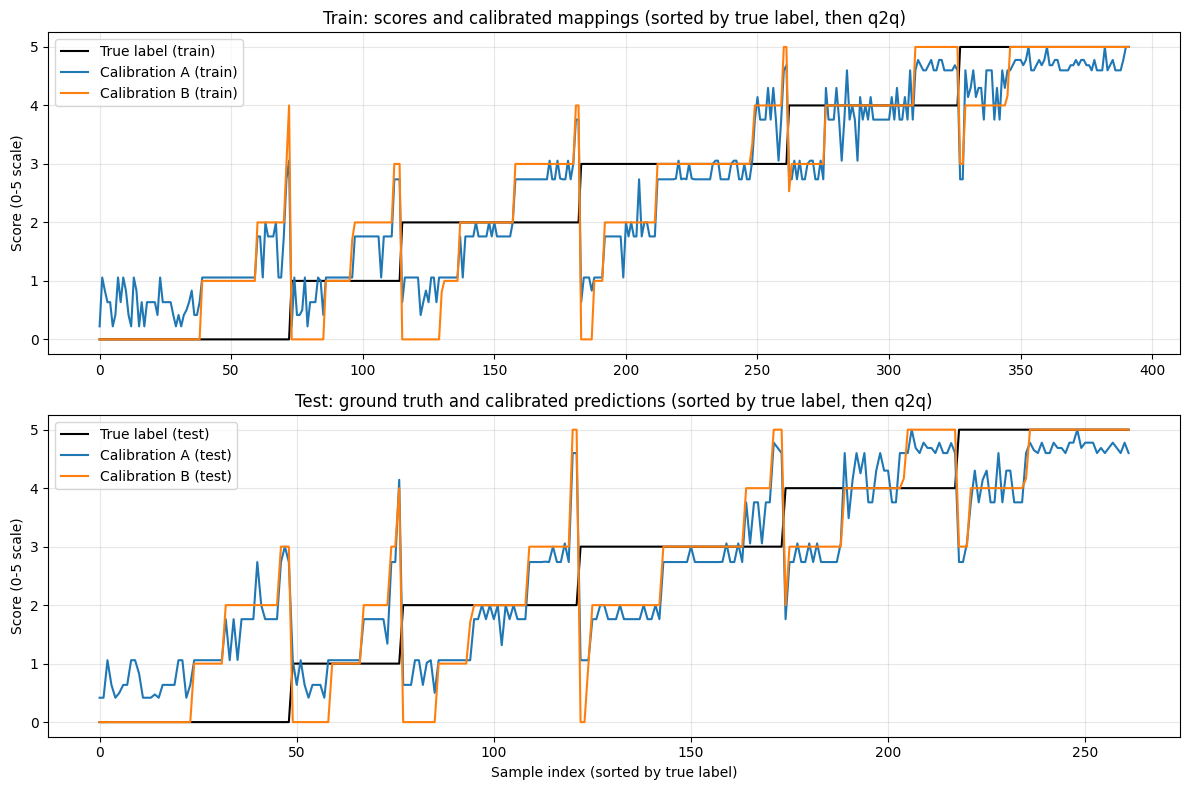

In [12]:
FILE_IDX = 0
MODEL_IDX = 0

# Ensure we have items loaded
files = sorted(METRICS_DIR.glob("*.json"))
items = load_metric_files(files)

df_train, df_test = load_train_test_data(DATA_DIR)
score_data = to_model_score_data(items, df_train, df_test)
sd = score_data[0] if score_data else None
if sd is None:
    raise RuntimeError("No score data available for calibration visualization")

print(f"Selected model: {sd.model_name}")
print(f"Train scores: {sd.train_scores.shape} values")

iso = IsotonicCalibration()
q2q = Q2QCalibration()

iso_cal = iso.fit(sd.train_scores, sd.y_train)
q2q_cal = q2q.fit(sd.train_scores, sd.y_train)

iso_train_pred = iso_cal.predict(sd.train_scores)
q2q_train_pred = q2q_cal.predict(sd.train_scores)

iso_test_pred = iso_cal.predict(sd.test_scores) if sd.test_scores is not None else None
q2q_test_pred = q2q_cal.predict(sd.test_scores) if sd.test_scores is not None else None


def _align_and_sort_local(scores, labels, a_pred, b_pred, sort_by_b=False):
    min_len = min(len(scores), len(labels), len(a_pred), len(b_pred))
    scores_aligned = scores[:min_len]
    labels_aligned = labels[:min_len]
    a_pred_aligned = a_pred[:min_len]
    b_pred_aligned = b_pred[:min_len]
    secondary = b_pred_aligned if sort_by_b else a_pred_aligned
    order = np.lexsort((secondary, labels_aligned))
    return (
        scores_aligned[order],
        labels_aligned[order],
        a_pred_aligned[order],
        b_pred_aligned[order],
    )


train_scores_sorted, y_train_sorted, iso_train_sorted, q2q_train_sorted = (
    _align_and_sort_local(
        sd.train_scores, sd.y_train, iso_train_pred, q2q_train_pred, sort_by_b=False
    )
)

if sd.y_test is not None and iso_test_pred is not None and q2q_test_pred is not None:
    _, y_test_sorted, iso_test_sorted, q2q_test_sorted = _align_and_sort_local(
        sd.test_scores, sd.y_test, iso_test_pred, q2q_test_pred, sort_by_b=False
    )
else:
    y_test_sorted = iso_test_sorted = q2q_test_sorted = None

plot_calibration_comparison(
    train_scores_sorted,
    y_train_sorted,
    iso_train_sorted,
    q2q_train_sorted,
    y_test_sorted,
    iso_test_sorted,
    q2q_test_sorted,
    title_suffix=" (sorted by true label, then isotonic)",
)

if sd.y_test is not None and iso_test_pred is not None and q2q_test_pred is not None:
    (
        train_scores_sorted_q2q,
        y_train_sorted_q2q,
        iso_train_sorted_q2q,
        q2q_train_sorted_q2q,
    ) = _align_and_sort_local(
        sd.train_scores, sd.y_train, iso_train_pred, q2q_train_pred, sort_by_b=True
    )
    _, y_test_sorted_q2q, iso_test_sorted_q2q, q2q_test_sorted_q2q = (
        _align_and_sort_local(
            sd.test_scores, sd.y_test, iso_test_pred, q2q_test_pred, sort_by_b=True
        )
    )

    plot_calibration_comparison(
        train_scores_sorted_q2q,
        y_train_sorted_q2q,
        iso_train_sorted_q2q,
        q2q_train_sorted_q2q,
        y_test_sorted_q2q,
        iso_test_sorted_q2q,
        q2q_test_sorted_q2q,
        title_suffix=" (sorted by true label, then q2q)",
    )

## Model Evaluation with Core Visualization

### Load and Convert Model Scores


In [2]:
SELECTED_DIR = METRICS_DIR
files = sorted(SELECTED_DIR.glob("*.json"))
items = load_metric_files(files)

df_train, df_test = load_train_test_data(DATA_DIR)
score_data = to_model_score_data(items, df_train, df_test)

MODEL_TO_EVAL = 0
if score_data:
    sd = score_data[MODEL_TO_EVAL]
    aggregated_models = [
        nli_scores_to_core(
            sd.train_scores,
            sd.y_train,
            sd.test_scores,
            sd.y_test,
            model_name=sd.model_name,
        )
    ]
    print(f"Converted {len(aggregated_models)} model(s) for evaluation")
    print(f"Model: {aggregated_models[0].model}")
else:
    print("No score data available")
    aggregated_models = []

Converted 1 model(s) for evaluation
Model: RoBERTa


### Configuration Selection

Select which configuration to evaluate. See available options below.

In [3]:
files = sorted(METRICS_DIR.glob("*.json"))
config_names = [f.stem for f in files]

print(f"Available configurations ({len(config_names)}):")
for idx, name in enumerate(config_names):
    print(f"  {idx}: {name}")

Available configurations (46):
  0: fttii_he_2025-12-23-15-53-16
  1: itttivitosdiavd_das_2025-12-23-16-04-17
  2: tcitti_ac_2025-12-23-15-09-00
  3: tcott_cc_2025-12-23-15-57-40
  4: tiitti_nsr_2025-12-23-16-10-42
  5: tilotti_nmlmhv_2025-12-23-16-35-30
  6: tlovditti_zmmgrf_2025-12-23-16-29-35
  7: tpd_nsodcf_2025-12-23-16-17-06
  8: tt_cc_2025-12-23-15-00-08
  9: tt_dd_2025-12-23-15-02-19
  10: tt_dd_2025-12-23-15-15-44
  11: tt_dd_2025-12-23-15-51-04
  12: tt_ic_2025-12-23-14-57-57
  13: tt_lc_2025-12-23-15-11-17
  14: tt_le_2025-12-23-15-39-56
  15: tt_li_2025-12-23-15-22-15
  16: tt_nc_2025-12-23-15-37-41
  17: tt_nd_2025-12-23-15-44-22
  18: tt_pp_2025-12-23-15-04-34
  19: ttd_ie_2025-12-23-15-26-39
  20: ttd_nv_2025-12-23-15-13-30
  21: ttd_so_2025-12-23-15-48-51
  22: ttdc_ac_2025-12-23-15-06-44
  23: ttdt_ww_2025-12-23-15-17-54
  24: tth_lh_2025-12-23-15-55-29
  25: tti_lr_2025-12-23-15-31-06
  26: tti_nc_2025-12-23-15-59-52
  27: tti_ns_2025-12-23-16-02-03
  28: tti_wi_2025-

In [4]:
SELECTED_CONFIG_IDX = 34
print(f"Selected configuration: {config_names[SELECTED_CONFIG_IDX]}")

Selected configuration: ttiitovdocsoe_nd_2025-12-23-14-39-35


### Specific Model Metrics Tables


In [5]:
filtered_score_data_specific = [
    sd for sd in score_data if sd.config_id == SELECTED_CONFIG_IDX
]
if filtered_score_data_specific:
    sd_specific = filtered_score_data_specific[0]
    specific_model = nli_scores_to_core(
        sd_specific.train_scores,
        sd_specific.y_train,
        sd_specific.test_scores,
        sd_specific.y_test,
        model_name=sd_specific.model_name,
        calibration_method=Q2QCalibration,
    )
    vis_specific_model_tables(specific_model)
else:
    print(f"No models found for configuration {SELECTED_CONFIG_IDX}")

TRAIN METRICS


,Label,Precision,Recall,F1,Support
0,0,0.5278,0.5205,0.5241,73
1,1,0.1905,0.1905,0.1905,42
2,2,0.3088,0.3088,0.3088,68
3,3,0.4500,0.4557,0.4528,79
4,4,0.4769,0.4769,0.4769,65
5,5,0.6923,0.6923,0.6923,65


Accuracy: 0.4566
MSE: 1.0487

CROSS-VALIDATION METRICS (Averaged Across Folds)


,Label,Precision,Recall,F1,Support
0,0,0.5395,0.5022,0.4961,14
1,1,0.2081,0.1811,0.1886,8
2,2,0.3100,0.3427,0.3052,13
3,3,0.4795,0.4751,0.4725,15
4,4,0.4569,0.4661,0.4591,13
5,5,0.7013,0.6851,0.6874,13


Accuracy: 0.4567
MSE: 1.0741

TEST METRICS


,Label,Precision,Recall,F1,Support
0,0,0.5349,0.4694,0.5000,49
1,1,0.1905,0.1429,0.1633,28
2,2,0.2759,0.3556,0.3107,45
3,3,0.4211,0.4615,0.4404,52
4,4,0.3571,0.3409,0.3488,44
5,5,0.5610,0.5227,0.5412,44


Accuracy: 0.4008
MSE: 1.1840

CROSS-VALIDATION METRICS - PER FOLD

--- Fold 1/5 ---


,Label,Precision,Recall,F1,Support
0,0,0.3529,0.5000,0.4138,12
1,1,0.2857,0.2222,0.2500,9
2,2,0.2222,0.1111,0.1481,18
3,3,0.2632,0.3846,0.3125,13
4,4,0.6471,0.6471,0.6471,17
5,5,0.8000,0.8000,0.8000,10


Accuracy: 0.4304
MSE: 1.0153

--- Fold 2/5 ---


,Label,Precision,Recall,F1,Support
0,0,0.6111,0.7333,0.6667,15
1,1,0.1000,0.1667,0.1250,6
2,2,0.4615,0.3333,0.3871,18
3,3,0.5333,0.4444,0.4848,18
4,4,0.4000,0.3333,0.3636,12
5,5,0.5385,0.7000,0.6087,10


Accuracy: 0.4684
MSE: 1.0127

--- Fold 3/5 ---


,Label,Precision,Recall,F1,Support
0,0,0.7000,0.3889,0.5000,18
1,1,0.0000,0.0000,0.0000,5
2,2,0.2941,0.3846,0.3333,13
3,3,0.5294,0.5294,0.5294,17
4,4,0.5000,0.6000,0.5455,10
5,5,0.9091,0.6667,0.7692,15


Accuracy: 0.4744
MSE: 0.9703

--- Fold 4/5 ---


,Label,Precision,Recall,F1,Support
0,0,0.7000,0.3889,0.5000,18
1,1,0.4545,0.4167,0.4348,12
2,2,0.1875,0.5000,0.2727,6
3,3,0.5455,0.4286,0.4800,14
4,4,0.4375,0.5000,0.4667,14
5,5,0.5714,0.5714,0.5714,14


Accuracy: 0.4615
MSE: 1.2564

--- Fold 5/5 ---


,Label,Precision,Recall,F1,Support
0,0,0.3333,0.5000,0.4000,10
1,1,0.2000,0.1000,0.1333,10
2,2,0.3846,0.3846,0.3846,13
3,3,0.5263,0.5882,0.5556,17
4,4,0.3000,0.2500,0.2727,12
5,5,0.6875,0.6875,0.6875,16


Accuracy: 0.4487
MSE: 1.1157


### Confusion Matrices


TRAIN SET CONFUSION MATRIX


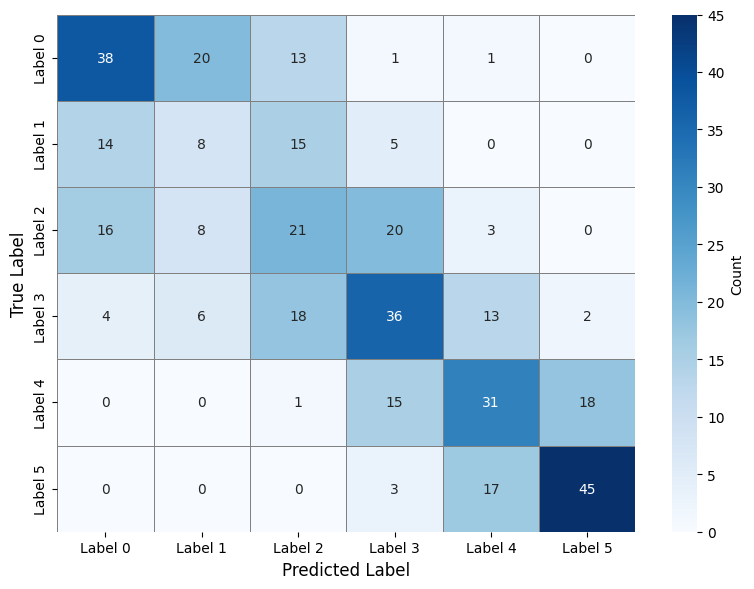


Confusion Matrix Statistics:
  Total predictions: 392
  Correct predictions (diagonal): 179
  Incorrect predictions (off-diagonal): 213
  Accuracy: 0.4566

Per-label statistics:
  Label 0: 38/73 correct (52.05%)
  Label 1: 8/42 correct (19.05%)
  Label 2: 21/68 correct (30.88%)
  Label 3: 36/79 correct (45.57%)
  Label 4: 31/65 correct (47.69%)
  Label 5: 45/65 correct (69.23%)

CROSS-VALIDATION CONFUSION MATRIX


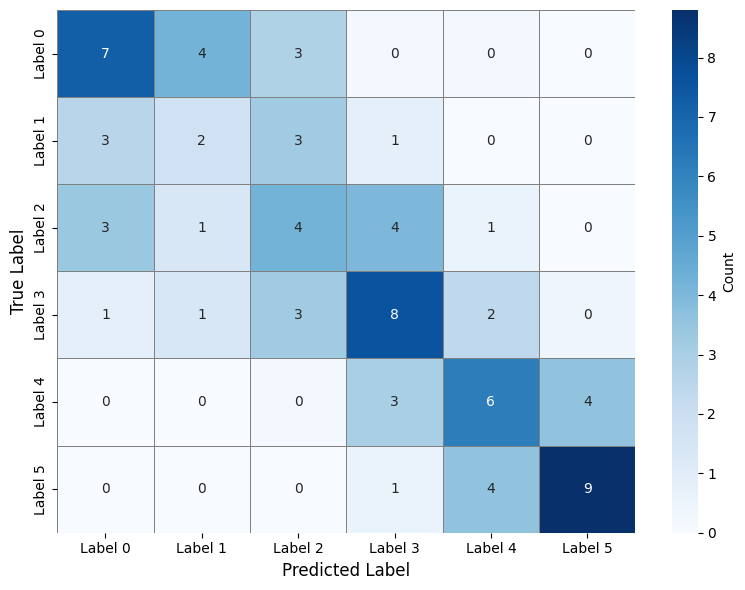


Confusion Matrix Statistics:
  Total predictions: 78.39999999999999
  Correct predictions (diagonal): 35.8
  Incorrect predictions (off-diagonal): 42.599999999999994
  Accuracy: 0.4566

Per-label statistics:
  Label 0: 7.2/14.599999999999998 correct (49.32%)
  Label 1: 1.8/8.4 correct (21.43%)
  Label 2: 4.2/13.6 correct (30.88%)
  Label 3: 7.6/15.8 correct (48.10%)
  Label 4: 6.2/13.0 correct (47.69%)
  Label 5: 8.8/13.0 correct (67.69%)

TEST SET CONFUSION MATRIX


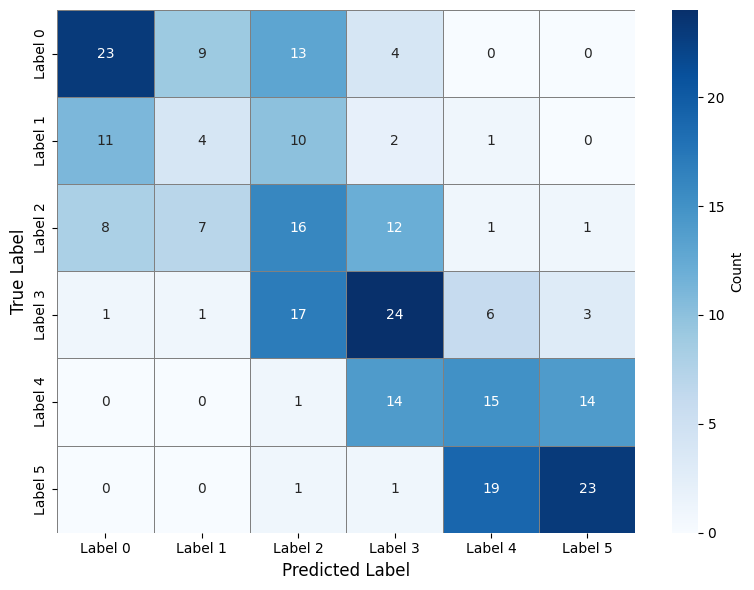


Confusion Matrix Statistics:
  Total predictions: 262
  Correct predictions (diagonal): 105
  Incorrect predictions (off-diagonal): 157
  Accuracy: 0.4008

Per-label statistics:
  Label 0: 23/49 correct (46.94%)
  Label 1: 4/28 correct (14.29%)
  Label 2: 16/45 correct (35.56%)
  Label 3: 24/52 correct (46.15%)
  Label 4: 15/44 correct (34.09%)
  Label 5: 23/44 correct (52.27%)


In [6]:
filtered_score_data_conf = [
    sd for sd in score_data if sd.config_id == SELECTED_CONFIG_IDX
]
if filtered_score_data_conf:
    sd_conf = filtered_score_data_conf[0]
    conf_model = nli_scores_to_core(
        sd_conf.train_scores,
        sd_conf.y_train,
        sd_conf.test_scores,
        sd_conf.y_test,
        model_name=sd_conf.model_name,
        calibration_method=Q2QCalibration,
    )
    vis_specific_model_conf_matrices(
        conf_model, show_proportional=False, show_title=False
    )
else:
    print(f"No models found for configuration {SELECTED_CONFIG_IDX}")

### Multiple Models Comparison


In [7]:
filtered_score_data = [sd for sd in score_data if sd.config_id == SELECTED_CONFIG_IDX]

multiple_models = []
for sd in filtered_score_data:
    converted = nli_scores_to_core(
        sd.train_scores,
        sd.y_train,
        sd.test_scores,
        sd.y_test,
        model_name=sd.model_name,
        calibration_method=Q2QCalibration,
    )
    multiple_models.append(converted)

print(
    f"Loaded {len(multiple_models)} model(s) from configuration {SELECTED_CONFIG_IDX}: {config_names[SELECTED_CONFIG_IDX]}"
)
for m in multiple_models:
    print(f"  - {m.model}")

richardr1126/roberta-base-zeroshot-v2.0-c-ONNX
richardr1126/deberta-v3-large-zeroshot-v2.0-ONNX
onnx-community/ModernBERT-large-zeroshot-v2.0-ONNX
Loaded 3 model(s) from configuration 34: ttiitovdocsoe_nd_2025-12-23-14-39-35
  - RoBERTa
  - DeBERTa-L
  - MBERT-L


#### Per-label metrics and model comparison plots


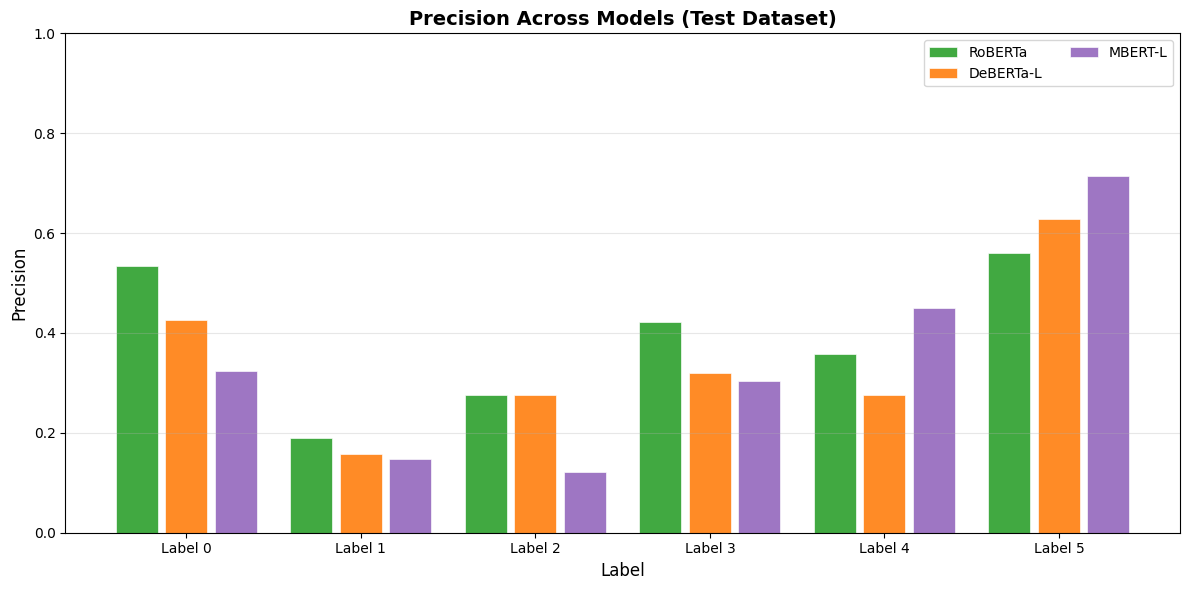

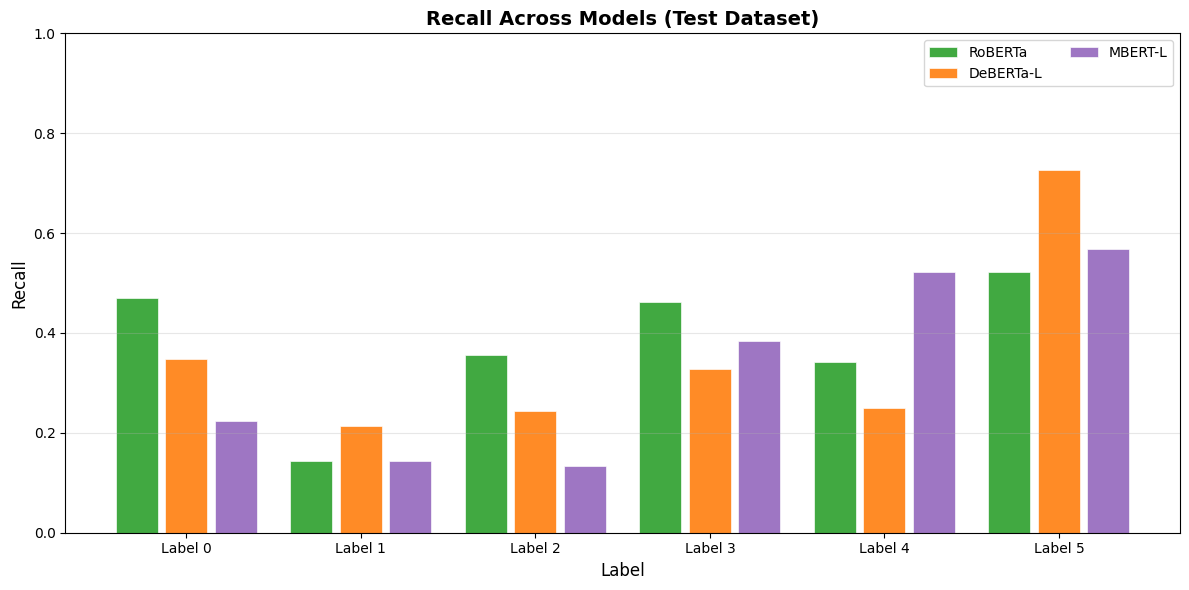

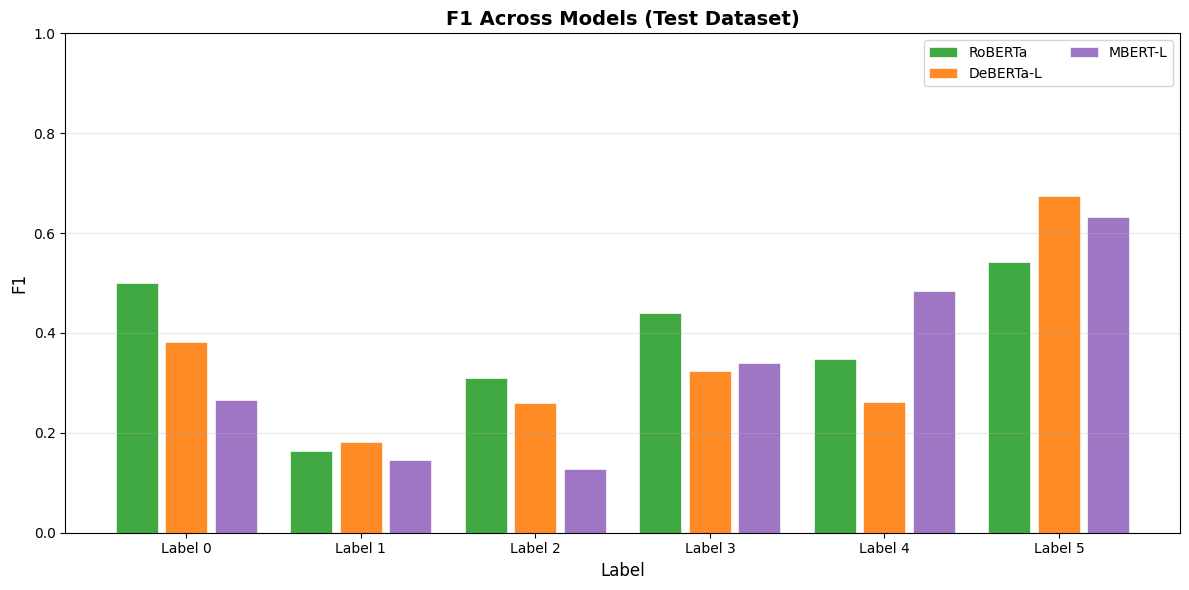

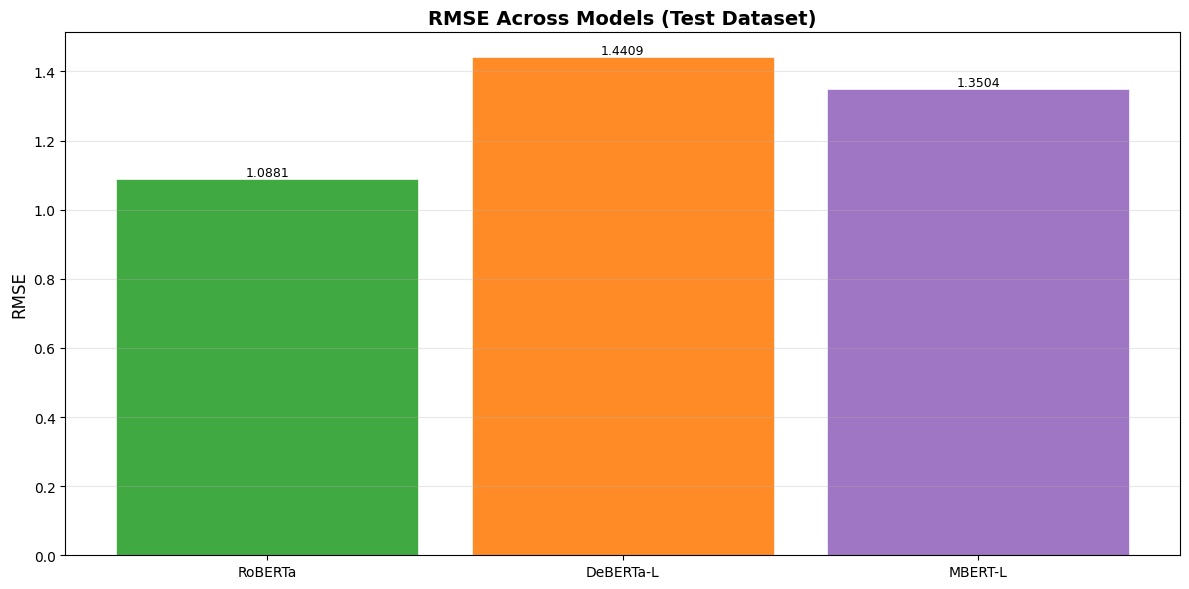

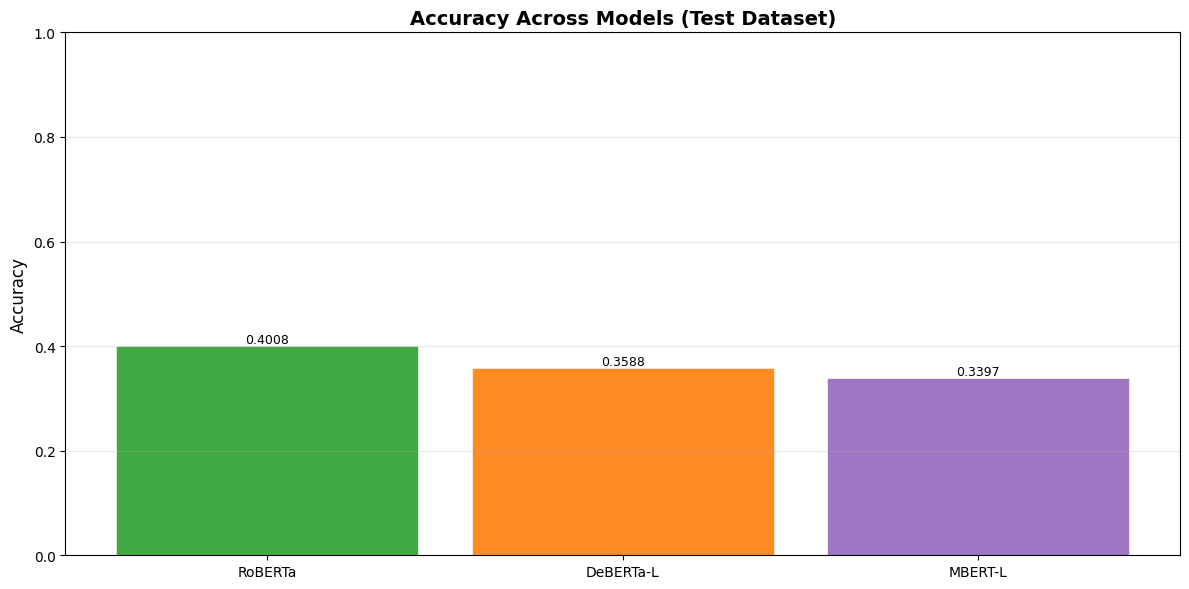

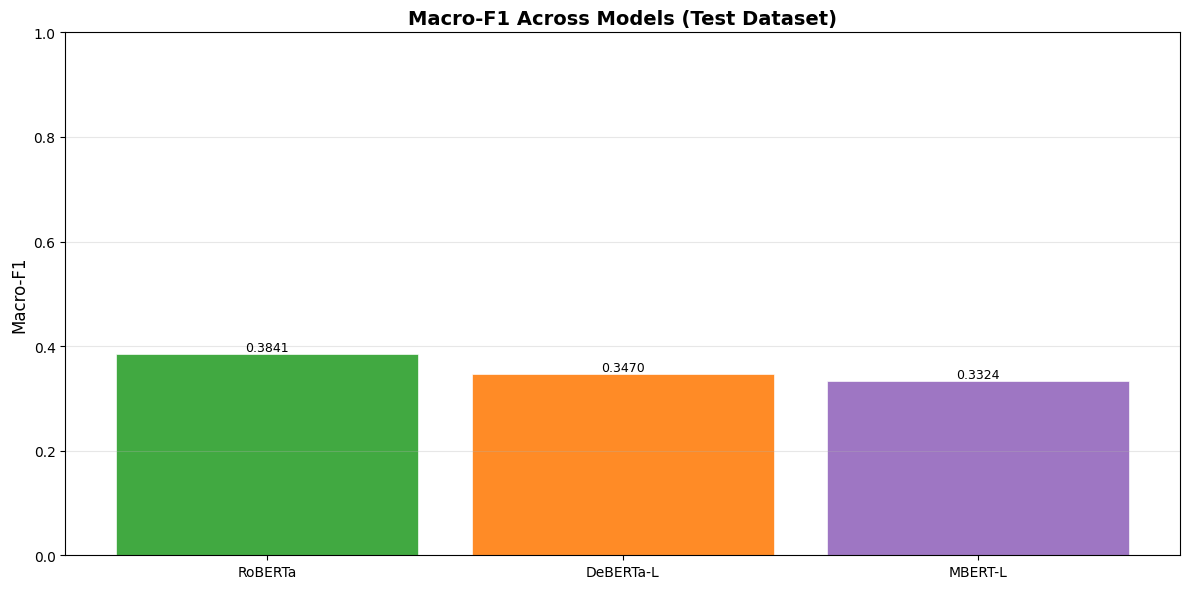

In [8]:
if multiple_models:
    vis_all_models_plots(multiple_models, "test")

#### Summary comparison table


In [9]:
if multiple_models:
    model_names = [m.model for m in multiple_models]
    model_groups, show_large_variants = get_nli_model_groups(model_names)
    df_metrics = vis_all_models_tables(
        multiple_models,
        ["RMSE", "Acc"],
        ["Train", "Test"],
        model_groups,
        show_large_variants,
    )
    latex_table = format_metrics_for_latex(df_metrics)
    print(latex_table)

,Model,Train RMSE,Test RMSE,Train Acc,Test Acc
0,RoBERTa,1.0241,1.0881,0.4566,0.4008
1,DeBERTa-L,1.4396,1.4409,0.3954,0.3588
2,MBERT-L,1.3486,1.3504,0.3878,0.3397


\begin{tabular}{rrrrr}
\toprule
\textbf{Model} & \textbf{Train RMSE} & \textbf{Test RMSE} & \textbf{Train Acc} & \textbf{Test Acc} \\
\midrule
RoBERTa & \textbf{1.0241} & \textbf{1.0881} & \textbf{0.4566} & \textbf{0.4008} \\
DeBERTa-L & 1.4396 & 1.4409 & 0.3954 & 0.3588 \\
MBERT-L & 1.3486 & 1.3504 & 0.3878 & 0.3397 \\
\bottomrule
\end{tabular}



/home/terra/Projects/vis-desc/modules/lab/src/evaluation/core.py:920: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{1.0241}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_latex.loc[idx, col] = (
/home/terra/Projects/vis-desc/modules/lab/src/evaluation/core.py:920: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{1.0881}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_latex.loc[idx, col] = (
/home/terra/Projects/vis-desc/modules/lab/src/evaluation/core.py:920: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{0.4566}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_latex.loc[idx, col] = 

## Relaxed Class Mode (merge 0/1, 2/3, 4/5)
These evaluations recompute metrics and confusion matrices after collapsing labels into three classes.

TRAIN SET CONFUSION MATRIX


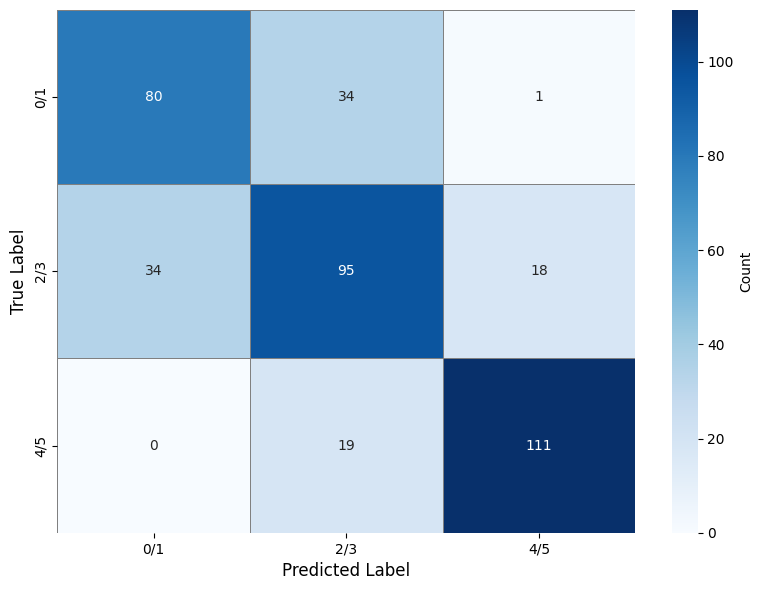


Confusion Matrix Statistics:
  Total predictions: 392
  Correct predictions (diagonal): 286
  Incorrect predictions (off-diagonal): 106
  Accuracy: 0.7296

Per-label statistics:
  Label 0: 80/115 correct (69.57%)
  Label 1: 95/147 correct (64.63%)
  Label 2: 111/130 correct (85.38%)

CROSS-VALIDATION CONFUSION MATRIX


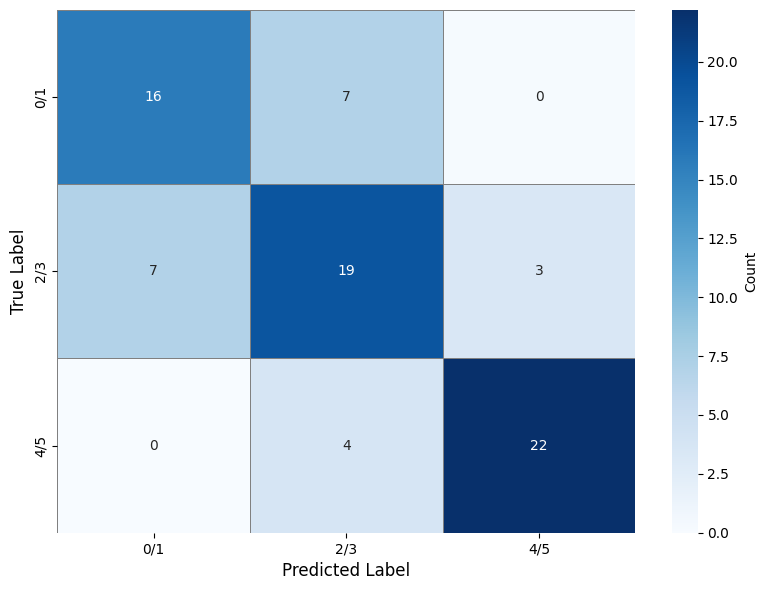


Confusion Matrix Statistics:
  Total predictions: 78.4
  Correct predictions (diagonal): 57.0
  Incorrect predictions (off-diagonal): 21.400000000000006
  Accuracy: 0.7270

Per-label statistics:
  Label 0: 15.8/23.0 correct (68.70%)
  Label 1: 19.0/29.4 correct (64.63%)
  Label 2: 22.200000000000003/26.000000000000004 correct (85.38%)

TEST SET CONFUSION MATRIX


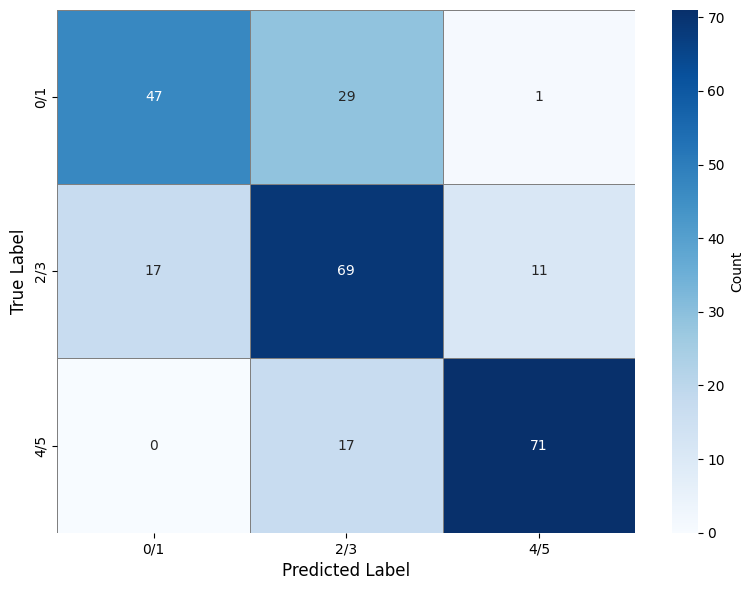


Confusion Matrix Statistics:
  Total predictions: 262
  Correct predictions (diagonal): 187
  Incorrect predictions (off-diagonal): 75
  Accuracy: 0.7137

Per-label statistics:
  Label 0: 47/77 correct (61.04%)
  Label 1: 69/97 correct (71.13%)
  Label 2: 71/88 correct (80.68%)


In [10]:
# Specific model: relaxed confusion matrices
filtered_score_data_relaxed = [
    sd for sd in score_data if sd.config_id == SELECTED_CONFIG_IDX
]
if filtered_score_data_relaxed:
    sd_relaxed = filtered_score_data_relaxed[0]
    relaxed_conf_model = nli_scores_to_core(
        sd_relaxed.train_scores,
        sd_relaxed.y_train,
        sd_relaxed.test_scores,
        sd_relaxed.y_test,
        model_name=sd_relaxed.model_name,
        calibration_method=Q2QCalibration,
    )
    vis_specific_model_conf_matrices(
        relaxed_conf_model,
        show_proportional=False,
        show_title=False,
        class_mode="relaxed",
    )
else:
    print(f"No models found for configuration {SELECTED_CONFIG_IDX}")

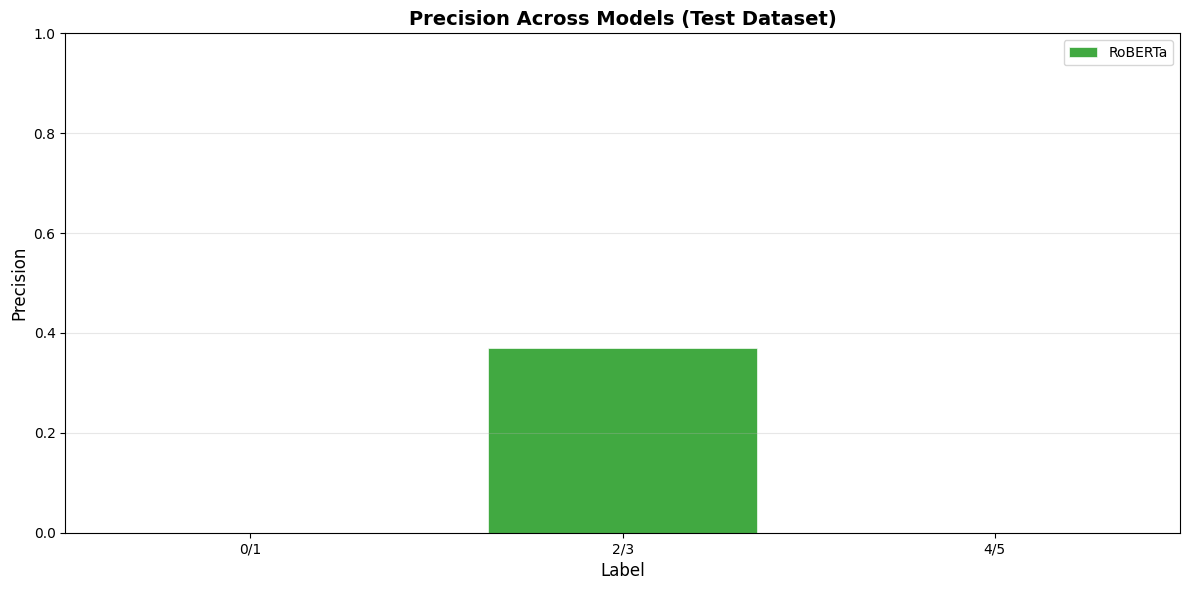

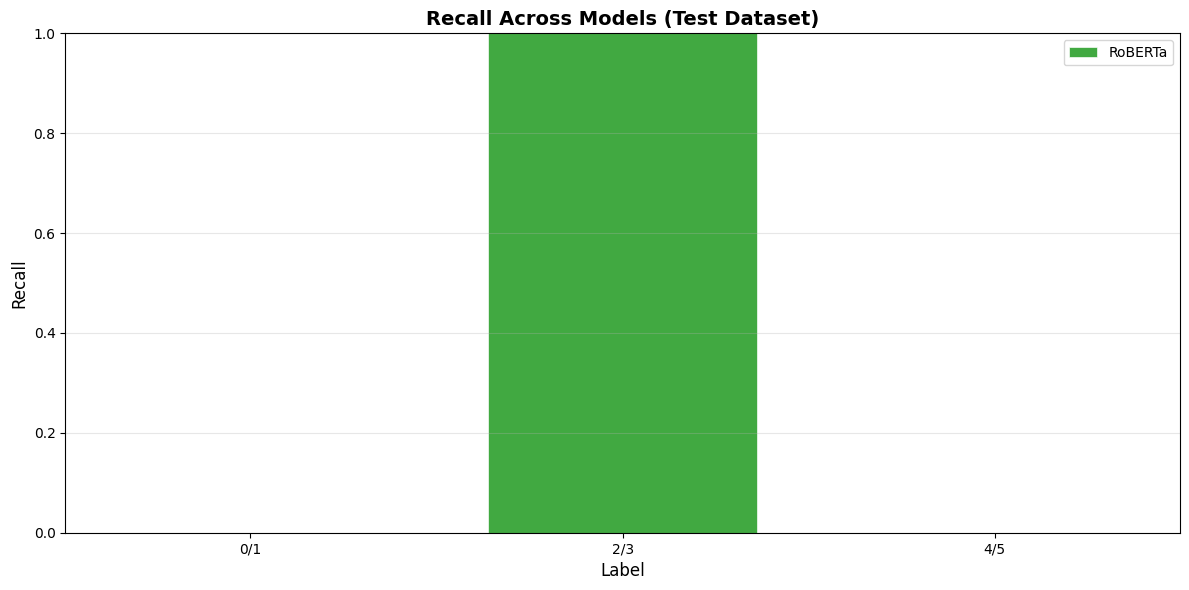

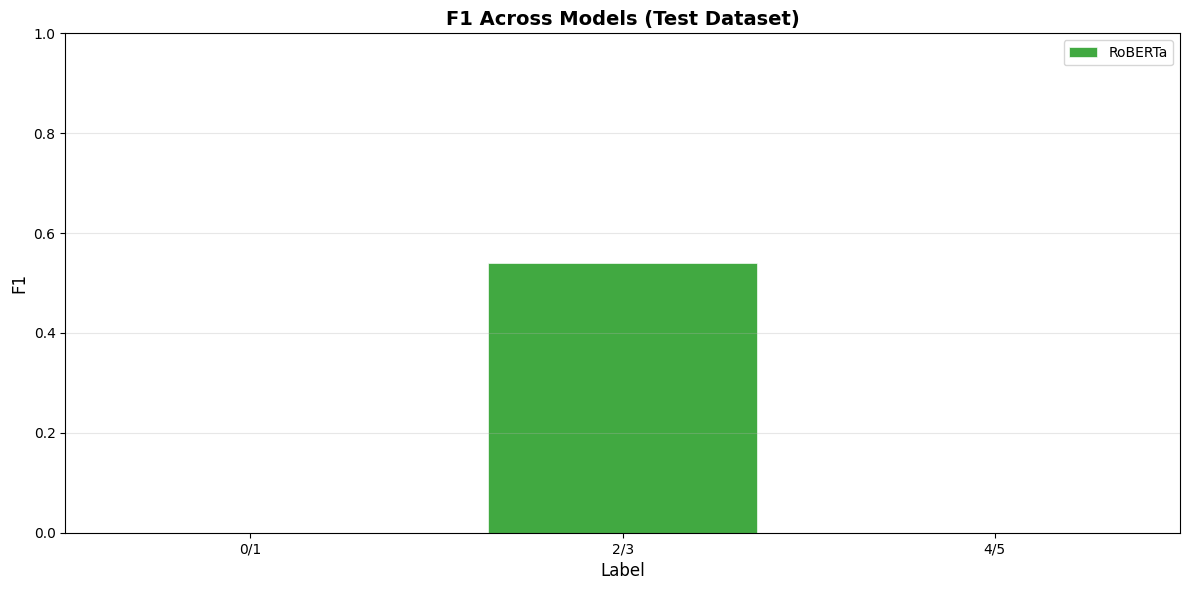

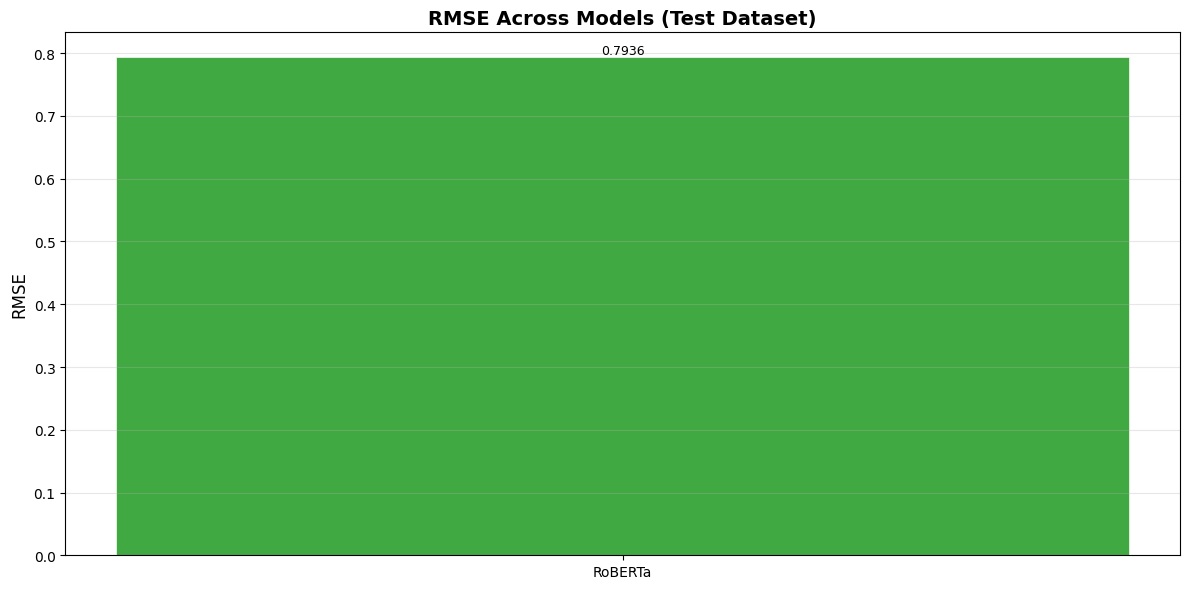

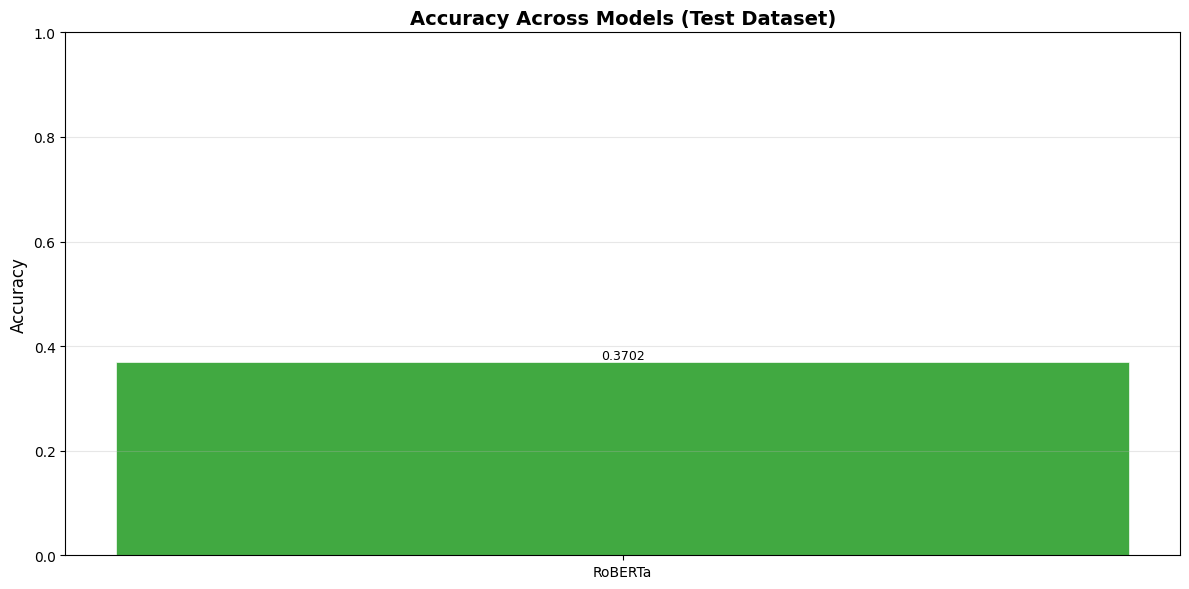

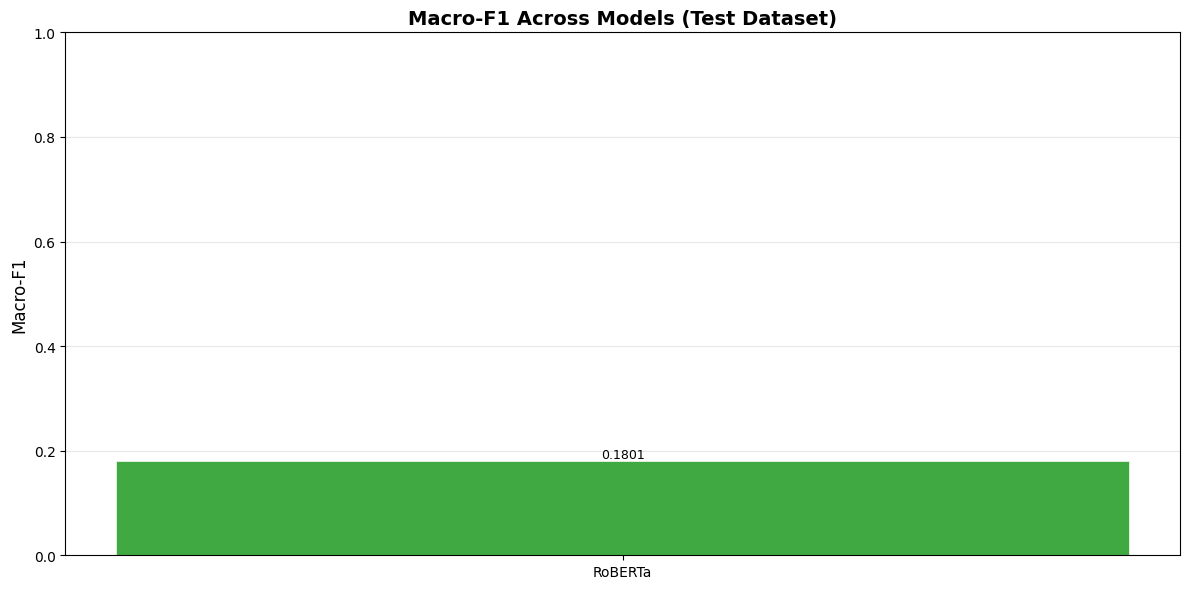

In [11]:
# All models: relaxed per-label plots on test split
vis_all_models_plots(aggregated_models, dataset="test", class_mode="relaxed")

In [12]:
# All models: relaxed comparison table (Train/Test, RMSE & Acc)
model_groups, show_large_variants = get_nli_model_groups(model_names)
df_metrics_relaxed = vis_all_models_tables(
    multiple_models,
    ["Acc"],
    ["Train", "Test"],
    model_groups,
    show_large_variants,
    class_mode="relaxed",
)
latex_table_relaxed = format_metrics_for_latex(df_metrics_relaxed)
print(latex_table_relaxed)

,Model,Train Acc,Test Acc
0,RoBERTa,0.7296,0.7137
1,DeBERTa-L,0.6071,0.5878
2,MBERT-L,0.6276,0.6031


\begin{tabular}{rrr}
\toprule
\textbf{Model} & \textbf{Train Acc} & \textbf{Test Acc} \\
\midrule
RoBERTa & \textbf{0.7296} & \textbf{0.7137} \\
DeBERTa-L & 0.6071 & 0.5878 \\
MBERT-L & 0.6276 & 0.6031 \\
\bottomrule
\end{tabular}



/home/terra/Projects/vis-desc/modules/lab/src/evaluation/core.py:920: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{0.7296}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_latex.loc[idx, col] = (
/home/terra/Projects/vis-desc/modules/lab/src/evaluation/core.py:920: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{0.7137}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_latex.loc[idx, col] = (
